In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans


import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
### DAVID : this is the path to my code and data folders, probably add yours

In [3]:
net = 'stepnet'#'highd_inputs'#'
### DAVID : this directs to a folder within the code from github
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import make_axes, same_stim_trial, comp_eig_decomp, name_best_ckpt, plot_FP, plot_N, get_T_inds
from tools_lnd import make_h_and_Jac, make_Jac_x, gen_trials_from_model_dir, gen_X_from_model_dir_epoch, gen_X_from_model_dir

In [4]:
def plot_h_mds_steps(X_transformed,n_interp,nfps,dot_alpha = .3):
    cmap=plt.get_cmap('rainbow')
        
    for ri in range(n_interp):
        c = cmap(ri/n_interp)
        X_trial = X_transformed[(ri*nfps):((ri+1)*nfps),:]
        plt.plot(X_trial[:,0],X_trial[:,1],'o',c = c,alpha = dot_alpha)

        
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    return

def plot_h_mds_steps_qstar(X_transformed,qstar_vals,size=20):
    
    cmap=plt.get_cmap('viridis')
    plt.scatter(X_transformed[:,0],X_transformed[:,1],size,-np.log10(qstar_vals),alpha = .5)

        
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    return

def get_filename(task_list,t,step):
    f = task_list[0]+'_'+task_list[1]+'_trial_'+str(t)+'_step_'+str(step)
    return f

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


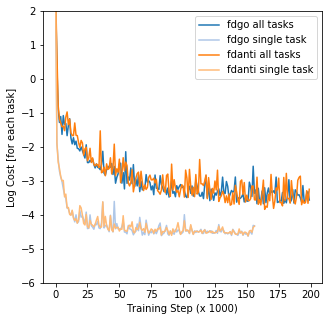

In [5]:
task_set = ['fdgo','fdanti']
model_n = 0
fig = plt.figure(figsize=(5, 5))

for r in range(len(task_set)):
    rule = task_set[r]

    dir_specific_single = 'crystals/softplus/single_tasks/l2w0001/'+rule 
    dir_specific_all = 'crystals/softplus/l2w0001'
    m_single = os.path.join(p,'data/rnn/multitask/',net,dir_specific_single,str(model_n))
    m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

    
    cmap = plt.get_cmap('tab20')
    c_ind = 0
    for m_ind in range(len([m_all, m_single])):
        m = [m_all, m_single][m_ind]
        m_label = rule+[' all tasks', ' single task'][m_ind]
        
        fname = os.path.join(m, 'log.json')

        with open(fname, 'r') as f:
            log_all = json.load(f)
            ax = fig.add_subplot(1,1,1)
            x = np.log(log_all['cost_'+rule])
            plt.plot(x,'-',c = cmap((2*r+m_ind)/20),label = m_label)

    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])

plt.legend()
plt.show()    

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


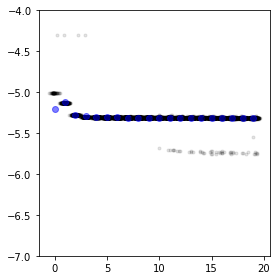

In [6]:
fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
epoch = 'stim1'
task_list = ['fdgo', 'fdanti']
# os.path.join(m_all,'fixed_pts_stepX_tasks_samesstim',epoch,task_list[0]+'_'+task_list[1])
step_file = 'fixed_pts_stepX_tasks_samesstim'
t = 10

for si in range(20):
    f = get_filename(task_list, t, si)
    filename = os.path.join(m_all,step_file,epoch,task_list[0]+'_'+task_list[1],f+'.npz')
    fp_struct = np.load(filename)
    plt.plot(si+.2*npr.randn(np.shape(fp_struct['qstar'])[0]),np.log10(fp_struct['qstar']),'.k',alpha = .1)
    plt.plot(si,np.mean(np.log10(fp_struct['qstar'])),'ob',alpha = .5)
    
plt.ylim([-7,-4])    
plt.show()

In [7]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

#         if len(clist)!=S:
#             c = clist
#         else:
#             c = cmap(int(clist[s])/max(clist))

        c = clist

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = .5)
        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = linewidth, alpha = .5)
        plt.plot(X_trial[0,0],X_trial[0,1],'.',c = c, linewidth = linewidth, alpha = .5)
        
def plot_FP(X, D, eig_decomps, c='k'):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    S = np.shape(X)[0]
    lf = 7
    rf = 7
    
    for s in range(S):
        
        X_trial = np.dot(X[s,:],D.T)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
        if len(n_arg)>0:
            for arg in range(np.max(n_arg)):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2], c = c ,alpha = .2,linewidth = .5)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
        if len(n_arg)>0:
            for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .2,linewidth = .5)
            
        plt.plot(X_trial[0], X_trial[1], 'o', markerfacecolor = c, markeredgecolor = c, markersize = 10, alpha = .5)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/scipy/stats/stats.py:2251: RuntimeWarning: invalid value encountered in true_divide
  np.expand_dims(sstd, axis=axis))


fdgo_fdanti_trial_0_step_1
fdgo_fdanti_trial_0_step_2
fdgo_fdanti_trial_0_step_3
fdgo_fdanti_trial_0_step_4
fdgo_fdanti_trial_0_step_5
fdgo_fdanti_trial_0_step_6
fdgo_fdanti_trial_0_step_7
fdgo_fdanti_trial_0_step_8
fdgo_fdanti_trial_0_step_9
fdgo_fdanti_trial_0_step_10
fdgo_fdanti_trial_0_step_11
fdgo_fdanti_trial_0_step_12
fdgo_fdanti_trial_0_step_13
fdgo_fdanti_trial_0_step_14
fdgo_fdanti_trial_0_step_15
fdgo_fdanti_trial_0_step_16
fdgo_fdanti_trial_0_step_17
fdgo_fdanti_trial_0_step_18
fdgo_fdanti_trial_0_step_19


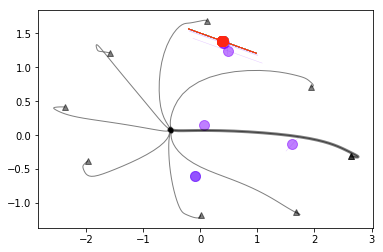

fdgo_fdanti_trial_10_step_0
fdgo_fdanti_trial_10_step_1
fdgo_fdanti_trial_10_step_2
fdgo_fdanti_trial_10_step_3
fdgo_fdanti_trial_10_step_4
fdgo_fdanti_trial_10_step_5
fdgo_fdanti_trial_10_step_6
fdgo_fdanti_trial_10_step_7
fdgo_fdanti_trial_10_step_8
fdgo_fdanti_trial_10_step_9
fdgo_fdanti_trial_10_step_10
fdgo_fdanti_trial_10_step_11
fdgo_fdanti_trial_10_step_12
fdgo_fdanti_trial_10_step_13
fdgo_fdanti_trial_10_step_14
fdgo_fdanti_trial_10_step_15
fdgo_fdanti_trial_10_step_16
fdgo_fdanti_trial_10_step_17
fdgo_fdanti_trial_10_step_18
fdgo_fdanti_trial_10_step_19


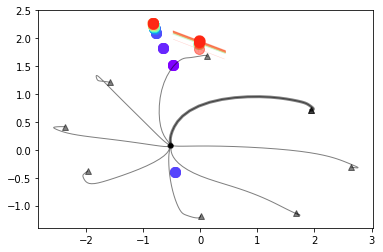

fdgo_fdanti_trial_20_step_0
fdgo_fdanti_trial_20_step_1
fdgo_fdanti_trial_20_step_2
fdgo_fdanti_trial_20_step_3
fdgo_fdanti_trial_20_step_4
fdgo_fdanti_trial_20_step_5
fdgo_fdanti_trial_20_step_6
fdgo_fdanti_trial_20_step_7
fdgo_fdanti_trial_20_step_8
fdgo_fdanti_trial_20_step_9
fdgo_fdanti_trial_20_step_10
fdgo_fdanti_trial_20_step_11
fdgo_fdanti_trial_20_step_12
fdgo_fdanti_trial_20_step_13
fdgo_fdanti_trial_20_step_14
fdgo_fdanti_trial_20_step_15
fdgo_fdanti_trial_20_step_16
fdgo_fdanti_trial_20_step_17
fdgo_fdanti_trial_20_step_18
fdgo_fdanti_trial_20_step_19


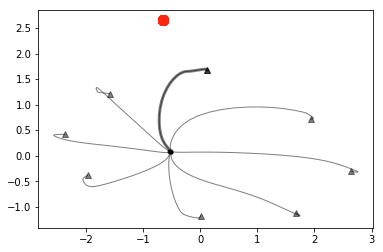

fdgo_fdanti_trial_30_step_0
fdgo_fdanti_trial_30_step_1
fdgo_fdanti_trial_30_step_2
fdgo_fdanti_trial_30_step_3
fdgo_fdanti_trial_30_step_4
fdgo_fdanti_trial_30_step_5
fdgo_fdanti_trial_30_step_6
fdgo_fdanti_trial_30_step_7
fdgo_fdanti_trial_30_step_8
fdgo_fdanti_trial_30_step_9
fdgo_fdanti_trial_30_step_10
fdgo_fdanti_trial_30_step_11
fdgo_fdanti_trial_30_step_12
fdgo_fdanti_trial_30_step_13
fdgo_fdanti_trial_30_step_14
fdgo_fdanti_trial_30_step_15
fdgo_fdanti_trial_30_step_16
fdgo_fdanti_trial_30_step_17
fdgo_fdanti_trial_30_step_18
fdgo_fdanti_trial_30_step_19


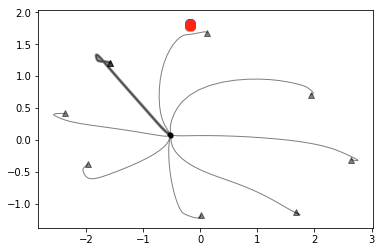

fdgo_fdanti_trial_40_step_0
fdgo_fdanti_trial_40_step_1
fdgo_fdanti_trial_40_step_2
fdgo_fdanti_trial_40_step_3
fdgo_fdanti_trial_40_step_4
fdgo_fdanti_trial_40_step_5
fdgo_fdanti_trial_40_step_6
fdgo_fdanti_trial_40_step_7
fdgo_fdanti_trial_40_step_8
fdgo_fdanti_trial_40_step_9
fdgo_fdanti_trial_40_step_10
fdgo_fdanti_trial_40_step_11
fdgo_fdanti_trial_40_step_12
fdgo_fdanti_trial_40_step_13
fdgo_fdanti_trial_40_step_14
fdgo_fdanti_trial_40_step_15
fdgo_fdanti_trial_40_step_16
fdgo_fdanti_trial_40_step_17
fdgo_fdanti_trial_40_step_18
fdgo_fdanti_trial_40_step_19


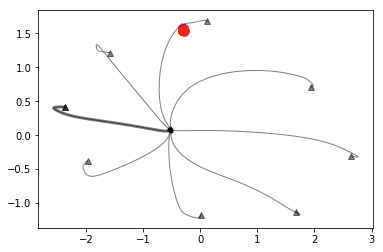

fdgo_fdanti_trial_50_step_0
fdgo_fdanti_trial_50_step_1
fdgo_fdanti_trial_50_step_2
fdgo_fdanti_trial_50_step_3
fdgo_fdanti_trial_50_step_4
fdgo_fdanti_trial_50_step_5
fdgo_fdanti_trial_50_step_6
fdgo_fdanti_trial_50_step_7
fdgo_fdanti_trial_50_step_8
fdgo_fdanti_trial_50_step_9
fdgo_fdanti_trial_50_step_10
fdgo_fdanti_trial_50_step_11
fdgo_fdanti_trial_50_step_12
fdgo_fdanti_trial_50_step_13
fdgo_fdanti_trial_50_step_14
fdgo_fdanti_trial_50_step_15
fdgo_fdanti_trial_50_step_16
fdgo_fdanti_trial_50_step_17
fdgo_fdanti_trial_50_step_18
fdgo_fdanti_trial_50_step_19


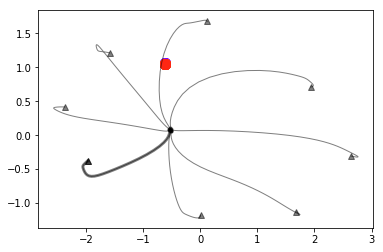

fdgo_fdanti_trial_60_step_0
fdgo_fdanti_trial_60_step_1
fdgo_fdanti_trial_60_step_2
fdgo_fdanti_trial_60_step_3
fdgo_fdanti_trial_60_step_4
fdgo_fdanti_trial_60_step_5
fdgo_fdanti_trial_60_step_6
fdgo_fdanti_trial_60_step_7
fdgo_fdanti_trial_60_step_8
fdgo_fdanti_trial_60_step_9
fdgo_fdanti_trial_60_step_10
fdgo_fdanti_trial_60_step_11
fdgo_fdanti_trial_60_step_12
fdgo_fdanti_trial_60_step_13
fdgo_fdanti_trial_60_step_14
fdgo_fdanti_trial_60_step_15
fdgo_fdanti_trial_60_step_16
fdgo_fdanti_trial_60_step_17
fdgo_fdanti_trial_60_step_18
fdgo_fdanti_trial_60_step_19


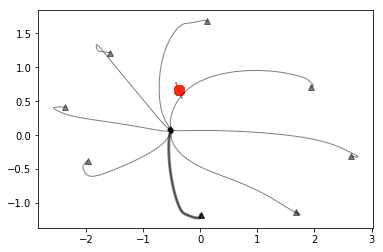

fdgo_fdanti_trial_70_step_0
fdgo_fdanti_trial_70_step_1
fdgo_fdanti_trial_70_step_2
fdgo_fdanti_trial_70_step_3
fdgo_fdanti_trial_70_step_4
fdgo_fdanti_trial_70_step_5
fdgo_fdanti_trial_70_step_6
fdgo_fdanti_trial_70_step_7
fdgo_fdanti_trial_70_step_8
fdgo_fdanti_trial_70_step_9
fdgo_fdanti_trial_70_step_10
fdgo_fdanti_trial_70_step_11
fdgo_fdanti_trial_70_step_12
fdgo_fdanti_trial_70_step_13
fdgo_fdanti_trial_70_step_14
fdgo_fdanti_trial_70_step_15
fdgo_fdanti_trial_70_step_16
fdgo_fdanti_trial_70_step_17
fdgo_fdanti_trial_70_step_18
fdgo_fdanti_trial_70_step_19


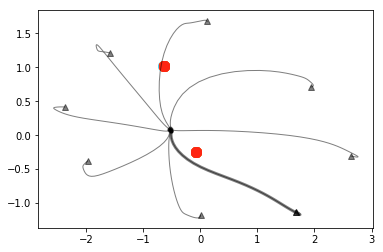

In [9]:
rule = 'fdgo'
epoch = 'stim1'
cmap = plt.get_cmap('rainbow')
n_interp = 20
n_fps_init = 50
n_fps = n_fps_init

trial = gen_trials_from_model_dir(m_all,rule,noise_on = False)
_,x1 = gen_X_from_model_dir(m_all,trial)
T_inds = get_T_inds(trial,epoch)
X1 = np.transpose(x1[:,:,T_inds],(1,2,0))
trial_set = range(0,80,10)

D = make_axes(m_all,rule,epoch)

# pca = PCA(n_components = 100)
# X = fp_steps
# _ = pca.fit_transform(X)
# D = pca.components_[:2,:].T

for t in range(0,80,10):
    for step_i in range(n_interp):
        
        f = get_filename(task_list, t, step_i)
        print(f)
        filename = os.path.join(m_all,step_file,epoch,task_list[0]+'_'+task_list[1],f+'.npz')
        fp_struct = np.load(filename)

        fp_sort = np.argsort(np.log10(fp_struct['qstar']))
        log10q = np.log10(fp_struct['qstar'])
        fp_num = fp_sort[log10q[fp_sort]<0][:10]
        eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_num,:,:])

        plot_FP(fp_struct['xstar'][fp_num,:], D.T, eig_decomps,c = cmap(step_i/n_interp))

    plot_N(X1[trial_set,:,:], D.T, 'k', alpha = .5)
    plot_N(X1[[t,],:,:], D.T, 'k', alpha = 1, linewidth = 3)
    # plot_N(X1[[40+t,],:,:], D.T, cmap((40+t)/80), alpha = 1)
    plt.show()

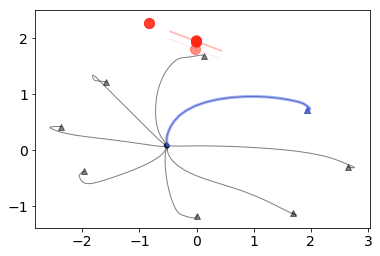

In [53]:
plot_FP(fp_struct['xstar'][fp_num,:], D.T, eig_decomps,c = cmap(step_i/n_interp))

plot_N(X1[trial_set,:,:], D.T, 'k', alpha = .5)
plot_N(X1[[t,],:,:], D.T, cmap(t/80), alpha = 1, linewidth = 3)
# plot_N(X1[[40+t,],:,:], D.T, cmap((40+t)/80), alpha = 1)
plt.show()

In [ ]:
## from tools_lnd import make_h_trial_rule, get_model_params, generate_Beta_epoch, make_fp_struct, comp_eig_decomp
plt.rcParams.update({'font.size': 20})

#output dynamics
dims ='tdr'
fp_file = 'tf_fixed_pts_all_init'
model_n = 0
    
dir_specific_single = 'crystals/softplus/single_tasks/l2w0001/'+rule 
m_single = os.path.join(p,'data/rnn/multitask/',net,dir_specific_single,str(model_n))
m_all = os.path.join(p,'data/rnn/multitask/',net,dir_specific_all,str(model_n))

r1 = 'fdgo'
r2 = 'fdanti'
epoch = 'stim1'
D_r1 = make_axes(m_all,r1,epoch)
D_r2 = make_axes(m_all,r2,epoch)
ind_stim_loc = 0

model = Model(m_all)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    
    trial_r1 = generate_trials(r1, hparams, mode='test', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial_r1, hparams)
    h_tf_r1 = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    X1 = np.transpose(h_tf_r1,(1,0,2))
    
    trial_r2 = same_stim_trial(trial_r1,3)
    feed_dict = tools.gen_feed_dict(model, trial_r2, hparams)
    h_tf_r2 = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    X2 = np.transpose(h_tf_r2,(1,0,2))

f = os.path.join(m_all,fp_file,r1,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
fp_struct1 = np.load(f)
eig_decomps1 = comp_eig_decomp(fp_struct1['J_xstar'])

f = os.path.join(m_all,fp_file,r2,epoch+'_'+str(round(ind_stim_loc,2))+'.npz')
fp_struct2 = np.load(f)
eig_decomps2 = comp_eig_decomp(fp_struct2['J_xstar'])

stim_inds = range(trial_r1.epochs['stim1'][0],trial_r1.epochs['stim1'][1])
trial_set = range(0,80,10)
X1_stim = X1[:, stim_inds,:]
X2_stim = X2[:, stim_inds,:]

In [25]:
epoch = 'stim1'
task_list = ['fdgo', 'fdanti']
t = 0
n_interp = 20
n_fps_init = 50
step_file = 'fixed_pts_stepX_tasks_samesstim'

def make_X_steps_epoch(m, step_file, rule, epoch, n_fps_init, t = 0, n_interp = 20):
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    _,x1 = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    inds_use = [int(x) for x in np.linspace(T_inds[1],x1.shape[2]-1,n_interp)]
    h_tf = x1[:,:,inds_use]
    fp_steps = []

    for step_i in range(n_interp):
        n_fps = n_fps_init

        f = get_filename(task_list, t, step_i)
        filename = os.path.join(m_all,step_file,epoch,task_list[0]+'_'+task_list[1],f+'.npz')
        fp_struct = np.load(filename)

        sorted_fps = fp_struct['xstar']
        if np.shape(sorted_fps)[0]>n_fps:
            kmeans = KMeans(n_clusters=n_fps, random_state=0).fit(sorted_fps)
            _,fp_inds = np.unique(kmeans.labels_,return_index=True)
        else: 
            fp_inds = range(np.shape(sorted_fps)[0])

        n_fps = len(fp_inds)
        dst_FP = np.zeros((n_fps))
        for s in range(n_fps):
            dst_FP[s] = LA.norm(h_tf[:,t,step_i] - sorted_fps[fp_inds[s],:])

        sorted_inds = [fp_inds[int(x)] for x in np.argsort(dst_FP)]
        fps_sorted = sorted_fps[sorted_inds,:]

        if fp_steps == []:
            fp_steps = fps_sorted
            num_found = [np.shape(fps_sorted)[0],]
            qstar_vals = fp_struct['qstar'][sorted_inds]
        else:
            fp_steps = np.concatenate((fp_steps, fps_sorted), axis=0)
            num_found = num_found+ [np.shape(fps_sorted)[0],]
            qstar_vals = np.concatenate((qstar_vals,fp_struct['qstar'][sorted_inds]))
            
    X = np.squeeze(fp_steps).astype(np.float64)
    D = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    dst = np.zeros((np.shape(X)[0],np.shape(X)[0]))
    for xi in range(np.shape(X)[0]):
        for yi in range(np.shape(X)[0]):
            D[xi,yi] = LA.norm(X[xi,:]-X[yi,:])
            dst[xi,yi] = distance.euclidean(X[xi,:], X[yi,:])

    embedding = MDS(n_components = 2,dissimilarity = 'precomputed')
    X_steps = embedding.fit_transform(dst)
    
    return X_steps,dst,fp_steps,num_found,qstar_vals

In [26]:
rule = task_list[0]
X_steps,D,fp_steps,num_found,qstar_vals = make_X_steps_epoch(m_all, step_file, rule, epoch, n_fps_init)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitas

/Users/lauradriscoll/anaconda2/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


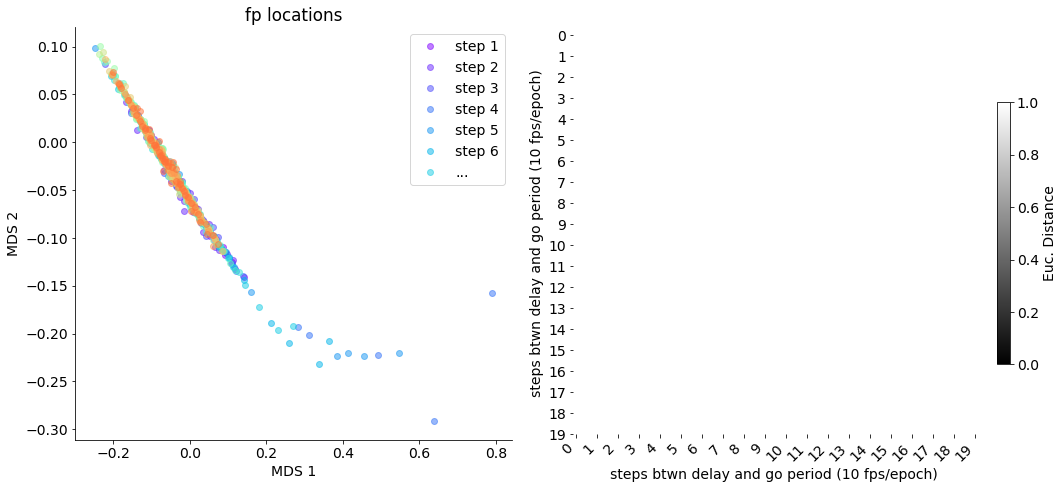

In [40]:
new_names = [str(step_i) for step_i in range(n_interp)]

fig = plt.figure(figsize=(15,7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

n_fps = 50

ax1 = plt.subplot(1,2,1)
plot_h_mds_steps(X_steps[56:,:],n_interp,n_fps,dot_alpha = .5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.legend((['step 1','step 2','step 3','step 4','step 5','step 6','...']))
plt.title('fp locations')
# plt.xlim((-.5,.5))
# plt.ylim((-.5,.5))

ax2 = plt.subplot(1,2,2)
# n_trials_each = 100
plt.imshow(D[56:,56:],'gray')
tick_locs = num_found#range(int(n_fps/2),n_fps*n_interp,n_fps)
plt.xticks(np.cumsum(num_found),range(len(num_found)),rotation = 45, ha="right", va="top")
plt.yticks(np.cumsum(num_found),range(len(num_found)))
plt.xlabel('steps btwn delay and go period (10 fps/epoch)')
plt.ylabel('steps btwn delay and go period (10 fps/epoch)')

cbar = plt.colorbar(fraction = .03)
cbar.set_label('Euc. Distance')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# figpath = os.path.join(m,'Output Prep Figure_fp_matters')
# figname = 'fp_dst.pdf'
# if not os.path.exists(figpath):
#     os.makedirs(figpath)
# plt.savefig(os.path.join(figpath,figname))
# plt.show()

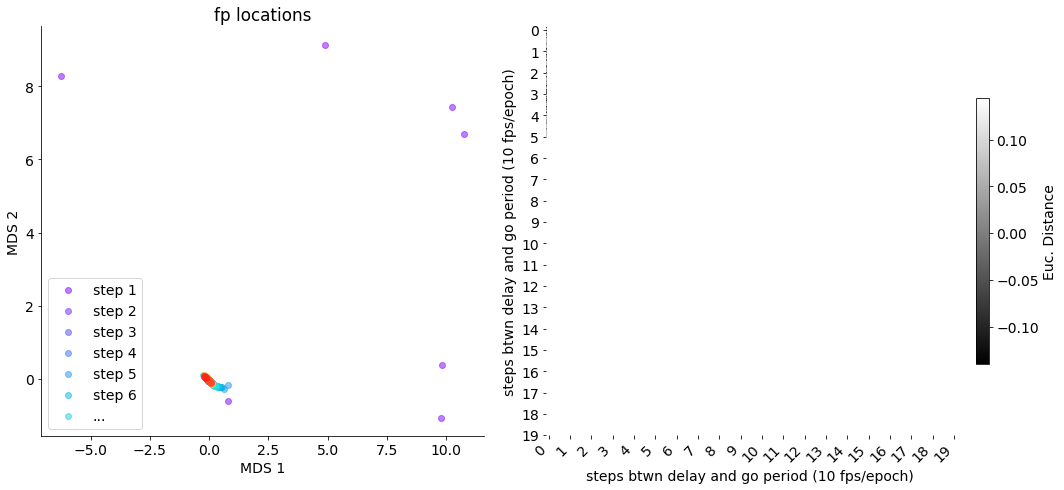

In [44]:
new_names = [str(step_i) for step_i in range(n_interp)]

fig = plt.figure(figsize=(15,7),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

n_fps = 50

ax1 = plt.subplot(1,2,1)
plot_h_mds_steps(X_steps,n_interp,n_fps,dot_alpha = .5)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.legend((['step 1','step 2','step 3','step 4','step 5','step 6','...']))
plt.title('fp locations')
# plt.xlim((-.5,.5))
# plt.ylim((-.5,.5))

ax2 = plt.subplot(1,2,2)
# n_trials_each = 100
plt.imshow(D,'gray')
tick_locs = num_found#range(int(n_fps/2),n_fps*n_interp,n_fps)
plt.xticks(np.cumsum(num_found),range(len(num_found)),rotation = 45, ha="right", va="top")
plt.yticks(np.cumsum(num_found),range(len(num_found)))
plt.xlabel('steps btwn delay and go period (10 fps/epoch)')
plt.ylabel('steps btwn delay and go period (10 fps/epoch)')

cbar = plt.colorbar(fraction = .03)
cbar.set_label('Euc. Distance')

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# figpath = os.path.join(m,'Output Prep Figure_fp_matters')
# figname = 'fp_dst.pdf'
# if not os.path.exists(figpath):
#     os.makedirs(figpath)
# plt.savefig(os.path.join(figpath,figname))
# plt.show()

In [55]:
np.shape(D)

(256, 2)